# Sementic segmentation of flair1 data with a basic UNet

In [11]:
!git clone https://github.com/BertilleT/LandCover_map_Transformers_SSL.git
!pip install rasterio

Cloning into 'LandCover_map_Transformers_SSL'...
remote: Enumerating objects: 8612, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 8612 (delta 64), reused 179 (delta 49), pack-reused 8417
Receiving objects: 100% (8612/8612), 423.77 MiB | 25.92 MiB/s, done.
Resolving deltas: 100% (499/499), done.


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
cd LandCover_map_Transformers_SSL/src

/content/LandCover_map_Transformers_SSL/src


In [14]:
# import all the necessary modules
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from pathlib import Path
import random
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from ...tools.utils_Flair1 import *
from ...tools.metrics import PixelwiseMetrics

## Prepare the data
1) Download the data and split it into training, validation and test sets.
2) Analyse the balance of classes in the dataset.
3) Create a Dataloader
4) Load the data

In [49]:
class Flair1Dataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, seed = 42):
        super(Flair1Dataset, self).__init__()
        self.resize_transform = transforms.Resize((224, 224))
        self.resize_transform_l = transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST)
        self.folder_path = folder_path
        self.img_files = sorted(list(get_data_paths(Path(self.folder_path), 'image*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
        self.mask_files = sorted(list(get_data_paths(Path(self.folder_path), 'mask*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
        self.total = len(self.img_files)
        self.n_classes = 13
        self.n_inputs = 5

    def __len__(self):
        return self.total

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]

        data = rasterio.open(img_path).read()
        #data = data[0:3, :, :]
        label = rasterio.open(mask_path).read()
        label = label - 1

        # Process each channel of the image separately
        data_processed = []
        for i in range(data.shape[0]):  # Loop over the channels
            channel = data[i]
            channel_image = Image.fromarray(channel)
            transformed_channel = self.resize_transform(channel_image)
            data_processed.append(np.array(transformed_channel))

        # Stack the processed channels back together
        data_stacked = np.stack(data_processed, axis=0)

        # Convert the processed image back to tensor
        data_tensor = torch.tensor(data_stacked, dtype=torch.float32)

        # Convert label to PIL Image for resizing
        label = np.transpose(label, (1, 2, 0))
        label = transforms.ToPILImage()(label)
        label = self.resize_transform_l(label)
        #print values uniques in label
        # Convert back to tensor
        label = torch.from_numpy(np.array(label, dtype=np.uint8))
        label = label.long()

        #Turn data and label into float between 0 and 1
        data_tensor = data_tensor / 255.0
        # label = label / 255
        return data_tensor, label

    def get_per_per_class(self):
        class_per = dict.fromkeys(range(1,20), 0)
        total_pixels = 0
        for i in range(len(self)):
            _, label = self[i]
            for j in range(1,20):
                class_per[j] += torch.sum(label == j).item()
            total_pixels += label.numel()
        for j in range(1,20):
            class_per[j] = class_per[j] / total_pixels
        return class_per


In [54]:
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.colors as mcolors

def plot_image_mask_2(image, mask, colors, dict_classes):
    mask = mask + 1  # Ensure mask classes start from 1
    image = image[0:3, :, :]
    image = image.permute(1, 2, 0)  # Change shape from (C, H, W) to (H, W, C)
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    ax[0].imshow(image.numpy())  # Assuming image is a Tensor
    ax[0].grid(False)

    # Extract unique classes present in the mask
    classes = np.unique(mask.numpy())  # Assuming mask is a Tensor

    # Generate a list of colors for the existing classes in the mask
    legend_colors = [colors[c] for c in classes]

    # Create a custom colormap
    custom_cmap = mcolors.ListedColormap(legend_colors)

    # Display the mask using the custom colormap
    ax[1].imshow(mask.numpy(), cmap=custom_cmap)
    ax[1].grid(False)

    # Add the legend entries for the classes present in the mask
    for c in classes:
        ax[1].plot([], [], color=colors[c], label=dict_classes[c])

    ax[1].legend()

    plt.show()
    return None

def plot_pred(img, pred, target, dict_classes, colors):
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    img = img[0:3, :, :]
    ax[0].imshow(img.permute(1, 2, 0))
    ax[0].grid(False)
    pred_single_channel = np.argmax(pred.numpy(), axis=0)
    pred_single_channel = pred_single_channel + 1
    target = target + 1
    pred_classes = np.unique(pred_single_channel)
    target_classes = np.unique(target)

    pred_legend_colors = [colors[c] for c in pred_classes]
    target_legend_colors = [colors[c] for c in target_classes]

    pred_custom_cmap = mcolors.ListedColormap(pred_legend_colors)
    target_custom_cmap = mcolors.ListedColormap(target_legend_colors)
    ax[1].imshow(pred_single_channel, cmap=pred_custom_cmap)
    ax[1].grid(False)
    ax[2].imshow(target, cmap=target_custom_cmap)
    ax[2].grid(False)
    # Add the legend entries for the classes present in the mask
    for c in pred_classes:
        ax[1].plot([], [], color=colors[c], label=dict_classes[c])
    for c in target_classes:
        ax[2].plot([], [], color=colors[c], label=dict_classes[c])

    ax[1].legend()
    ax[2].legend()
    plt.show()
    return None

In [48]:
my_set = 'fullset' # or 'subset'
data_config = {
    'train_path': '../../drive/MyDrive/MVA/flair1_' + my_set + '_13classes/train',
    'val_path': '../../drive/MyDrive/MVA/flair1_' + my_set + '_13classes/val',
    'test_path': '../../drive/MyDrive/MVA/flair1_' + my_set + '_13classes/test',
    'n_classes': 13, # number of classes in the dataset.
    'n_inputs': 5, # number of channels in input data
    'seed': 42,
    'batch_size': 32,
}

In [55]:
train_ds = Flair1Dataset(data_config['train_path'])
val_ds = Flair1Dataset(data_config['val_path'])
test_ds = Flair1Dataset(data_config['test_path'])

In [56]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=data_config['batch_size'], shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=data_config['batch_size'], shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=data_config['batch_size'], shuffle=True)

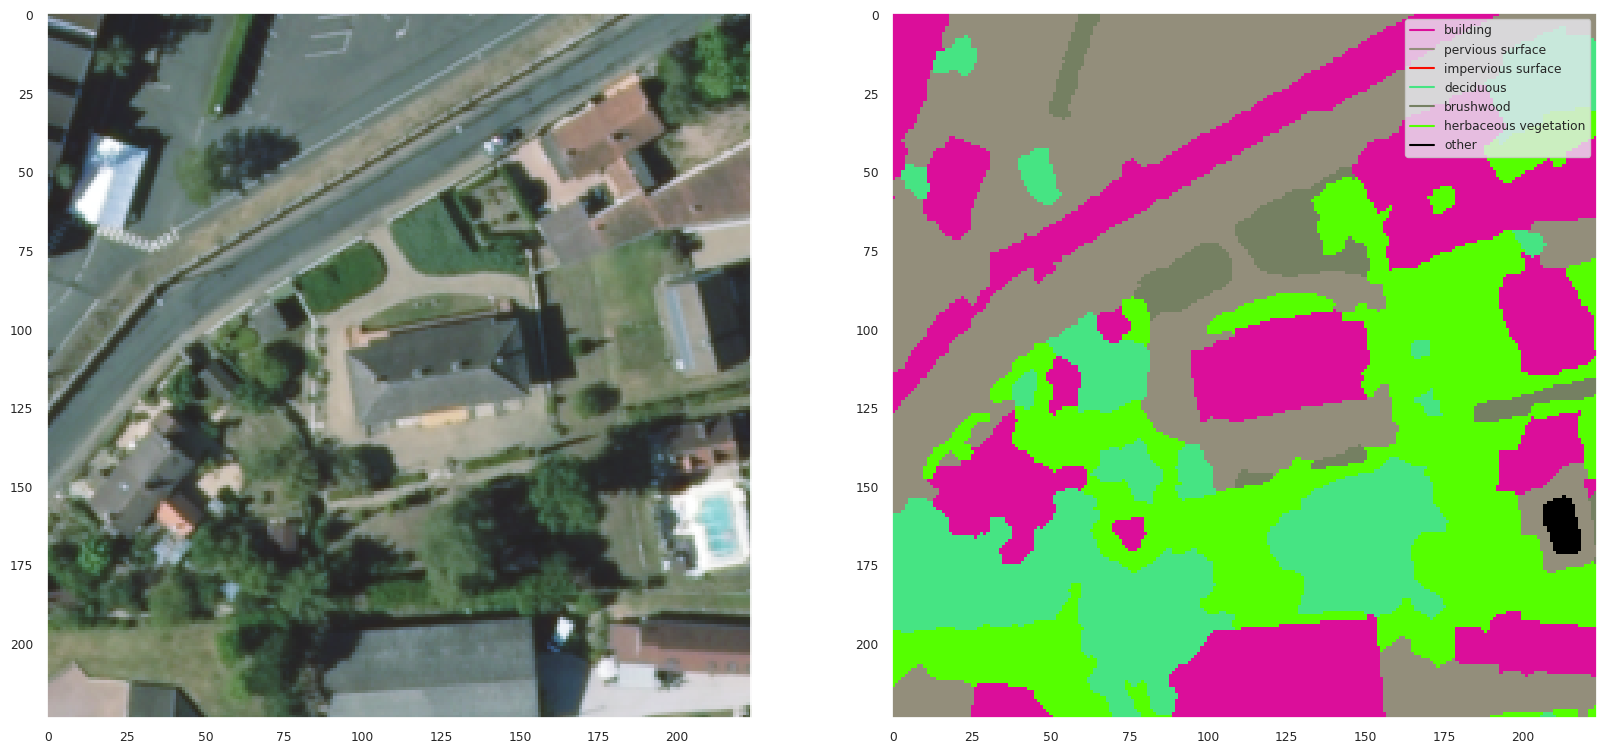

In [57]:
img, msk = next(iter(train_dl))
plot_image_mask_2(img[0], msk[0], colors_13, dict_classes_13)

## Create the model

In [59]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [60]:
# Training configurations
train_config = {
    'learning_rate': 0.01,
    'batch_size': 16,
    'epochs': 20,
    'seed': 42,
    'weight_decay': 5e-4,
    'model_path': '../../drive/MyDrive/MVA/UNet_20.pth',
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [61]:
model = UNet(n_classes=data_config['n_classes'], n_channels=data_config['n_inputs']) #pixel value from 1 to 13 and 5 channels
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255, reduction='mean').to(device)
optimizer = torch.optim.RMSprop(
    model.parameters(),
    lr=train_config['learning_rate'],
    weight_decay=train_config['weight_decay']
)

optimizer = torch.optim.Adam(
    parameters,
    lr=train_config['learning_rate'],
    betas=train_config['adam_betas'],
    weight_decay=train_config['weight_decay'],
)


## Train and validate

Epoch:0, Training Loss:1.617: 100%|██████████| 52/52 [04:46<00:00,  5.52s/it]


{'train_loss': 1.6174049377441406, 'train_average_accuracy': 0.24919397746873034, 'train_mIoU': 0.15732300413413514, 'train_accuracy_pixelclass_0': 0.28316103529382847, 'train_accuracy_pixelclass_1': 0.1803542694909483, 'train_accuracy_pixelclass_2': 0.566520505807998, 'train_accuracy_pixelclass_3': 3.874642402794909e-06, 'train_accuracy_pixelclass_4': 0.5525163964082073, 'train_accuracy_pixelclass_5': 0.0422644464708868, 'train_accuracy_pixelclass_6': 0.7287579665815737, 'train_accuracy_pixelclass_7': 0.05280359451527786, 'train_accuracy_pixelclass_8': 0.020904912933014302, 'train_accuracy_pixelclass_9': 0.7595381481569676, 'train_accuracy_pixelclass_10': 0.04280529942797578, 'train_accuracy_pixelclass_11': 0.009791397621960834, 'train_accuracy_pixelclass_12': 9.985974245264606e-05, 'train_IoU_class_0': 0.21401479121893538, 'train_IoU_class_1': 0.1289651876379762, 'train_IoU_class_2': 0.3511022625756376, 'train_IoU_class_3': 3.857201266190602e-06, 'train_IoU_class_4': 0.34683761957391

Validation Loss:1.48: 100%|██████████| 13/13 [00:35<00:00,  2.75s/it]


Epoch:0 {'validation_loss': 1.4796842336654663, 'validation_average_accuracy': 0.28003919368913244, 'validation_mIoU': 0.16720837028734997, 'validation_accuracy_pixelclass_0': 0.0457213778115744, 'validation_accuracy_pixelclass_1': 0.09073040573570149, 'validation_accuracy_pixelclass_2': 0.49498873778034985, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.8000586983637831, 'validation_accuracy_pixelclass_5': 0.5790693775616975, 'validation_accuracy_pixelclass_6': 0.5532907151153448, 'validation_accuracy_pixelclass_7': 0.18085765402940038, 'validation_accuracy_pixelclass_8': 0.0, 'validation_accuracy_pixelclass_9': 0.8957925515608702, 'validation_accuracy_pixelclass_10': 0.0, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.04346861810598758, 'train_IoU_class_1': 0.07194180699989179, 'train_IoU_class_2': 0.3858845271922204, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.45088282725255335, 'train_I

Epoch:1, Training Loss:1.351: 100%|██████████| 52/52 [04:37<00:00,  5.34s/it]


{'train_loss': 1.350599765777588, 'train_average_accuracy': 0.32640595735325273, 'train_mIoU': 0.21612020665286394, 'train_accuracy_pixelclass_0': 0.6878225307148333, 'train_accuracy_pixelclass_1': 0.23803695683224832, 'train_accuracy_pixelclass_2': 0.688066451225632, 'train_accuracy_pixelclass_3': 0.0, 'train_accuracy_pixelclass_4': 0.7292911717620614, 'train_accuracy_pixelclass_5': 0.12714767125240878, 'train_accuracy_pixelclass_6': 0.8102472757930734, 'train_accuracy_pixelclass_7': 0.09993979832888775, 'train_accuracy_pixelclass_8': 0.00033201133242321645, 'train_accuracy_pixelclass_9': 0.8328186021942666, 'train_accuracy_pixelclass_10': 0.02952507605645146, 'train_accuracy_pixelclass_11': 4.99000999998004e-05, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.49009421664409514, 'train_IoU_class_1': 0.16382823885470207, 'train_IoU_class_2': 0.5085264377331172, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.4236787381534121, 'train_IoU_class_5': 0.10214128891052454, 'trai

Validation Loss:1.815: 100%|██████████| 13/13 [00:23<00:00,  1.78s/it]


Epoch:1 {'validation_loss': 1.815252423286438, 'validation_average_accuracy': 0.24865593950627568, 'validation_mIoU': 0.12313571967291659, 'validation_accuracy_pixelclass_0': 0.8334903664476282, 'validation_accuracy_pixelclass_1': 0.0056980202053120415, 'validation_accuracy_pixelclass_2': 0.07056333792899978, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.8726567317111474, 'validation_accuracy_pixelclass_5': 0.035718759093002504, 'validation_accuracy_pixelclass_6': 0.7325199060584947, 'validation_accuracy_pixelclass_7': 0.264237084018503, 'validation_accuracy_pixelclass_8': 0.0, 'validation_accuracy_pixelclass_9': 0.4176416061124123, 'validation_accuracy_pixelclass_10': 1.4020060837717328e-06, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.1883720319844437, 'train_IoU_class_1': 0.005562935241269324, 'train_IoU_class_2': 0.06817730191584778, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.566764

Epoch:2, Training Loss:1.302: 100%|██████████| 52/52 [04:35<00:00,  5.30s/it]


{'train_loss': 1.3016470670700073, 'train_average_accuracy': 0.3525006711219095, 'train_mIoU': 0.23981307886590073, 'train_accuracy_pixelclass_0': 0.6881085418756699, 'train_accuracy_pixelclass_1': 0.18295439391241894, 'train_accuracy_pixelclass_2': 0.703825650136176, 'train_accuracy_pixelclass_3': 0.0, 'train_accuracy_pixelclass_4': 0.7168893744019699, 'train_accuracy_pixelclass_5': 0.22893720665207487, 'train_accuracy_pixelclass_6': 0.8339851567225343, 'train_accuracy_pixelclass_7': 0.1049911761037945, 'train_accuracy_pixelclass_8': 0.2574904030447756, 'train_accuracy_pixelclass_9': 0.7937302019750673, 'train_accuracy_pixelclass_10': 0.026961978312521288, 'train_accuracy_pixelclass_11': 0.04463464144782146, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.4680016558058827, 'train_IoU_class_1': 0.13244034760484671, 'train_IoU_class_2': 0.49059656883902486, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.45004468678697407, 'train_IoU_class_5': 0.17632731368927787, 'train_Io

Validation Loss:1.79: 100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


Epoch:2 {'validation_loss': 1.790458083152771, 'validation_average_accuracy': 0.25048445913649375, 'validation_mIoU': 0.11130698346290421, 'validation_accuracy_pixelclass_0': 0.4936474803506635, 'validation_accuracy_pixelclass_1': 7.128890337298354e-06, 'validation_accuracy_pixelclass_2': 0.4352606764140185, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.9027409303948108, 'validation_accuracy_pixelclass_5': 0.0393376536536768, 'validation_accuracy_pixelclass_6': 0.9372183704324826, 'validation_accuracy_pixelclass_7': 0.06870486735467496, 'validation_accuracy_pixelclass_8': 0.0005019279663004625, 'validation_accuracy_pixelclass_9': 0.3788789333174536, 'validation_accuracy_pixelclass_10': 0.0, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.15106404742546042, 'train_IoU_class_1': 7.128048258923298e-06, 'train_IoU_class_2': 0.18290951443718179, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.312250

Epoch:3, Training Loss:1.159: 100%|██████████| 52/52 [04:12<00:00,  4.86s/it]


{'train_loss': 1.158988118171692, 'train_average_accuracy': 0.41184899641371686, 'train_mIoU': 0.29067985852438716, 'train_accuracy_pixelclass_0': 0.755296839640686, 'train_accuracy_pixelclass_1': 0.1892765570679135, 'train_accuracy_pixelclass_2': 0.7189284918539884, 'train_accuracy_pixelclass_3': 0.0, 'train_accuracy_pixelclass_4': 0.7864513211793132, 'train_accuracy_pixelclass_5': 0.3118428767063525, 'train_accuracy_pixelclass_6': 0.833534356128749, 'train_accuracy_pixelclass_7': 0.18925288021482398, 'train_accuracy_pixelclass_8': 0.6898483109732984, 'train_accuracy_pixelclass_9': 0.7687488356391763, 'train_accuracy_pixelclass_10': 0.05025880053626103, 'train_accuracy_pixelclass_11': 0.06059768343775761, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5061612389330723, 'train_IoU_class_1': 0.13938533589144275, 'train_IoU_class_2': 0.5279363091339868, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.5201610883460348, 'train_IoU_class_5': 0.23704103322322553, 'train_IoU_cla

Validation Loss:4.907: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Epoch:3 {'validation_loss': 4.906716823577881, 'validation_average_accuracy': 0.20372816424317144, 'validation_mIoU': 0.11231296510487522, 'validation_accuracy_pixelclass_0': 0.04666660607511131, 'validation_accuracy_pixelclass_1': 0.004394451686491771, 'validation_accuracy_pixelclass_2': 0.276971644927084, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.7421133728002595, 'validation_accuracy_pixelclass_5': 0.02358447844946362, 'validation_accuracy_pixelclass_6': 0.5231202622381099, 'validation_accuracy_pixelclass_7': 9.043485600510052e-05, 'validation_accuracy_pixelclass_8': 0.9978439379298052, 'validation_accuracy_pixelclass_9': 0.03368094619889828, 'validation_accuracy_pixelclass_10': 0.0, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.046303375233591015, 'train_IoU_class_1': 0.004370408033042918, 'train_IoU_class_2': 0.21698056599664273, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.560604

Epoch:4, Training Loss:1.161: 100%|██████████| 52/52 [04:10<00:00,  4.82s/it]


{'train_loss': 1.160714030265808, 'train_average_accuracy': 0.4052123098098717, 'train_mIoU': 0.2860637251597437, 'train_accuracy_pixelclass_0': 0.7475863167344439, 'train_accuracy_pixelclass_1': 0.19885998883952496, 'train_accuracy_pixelclass_2': 0.733185890604058, 'train_accuracy_pixelclass_3': 0.0, 'train_accuracy_pixelclass_4': 0.7610654077551486, 'train_accuracy_pixelclass_5': 0.33050328954018793, 'train_accuracy_pixelclass_6': 0.8099816314821819, 'train_accuracy_pixelclass_7': 0.13672687730971203, 'train_accuracy_pixelclass_8': 0.7209658464389302, 'train_accuracy_pixelclass_9': 0.7678190200801562, 'train_accuracy_pixelclass_10': 0.04746997749804216, 'train_accuracy_pixelclass_11': 0.013595781245945618, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5247818887154787, 'train_IoU_class_1': 0.14141112996685554, 'train_IoU_class_2': 0.5291885386412286, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.5200082184454093, 'train_IoU_class_5': 0.2348741262337081, 'train_IoU_cl

Validation Loss:1.391: 100%|██████████| 13/13 [00:21<00:00,  1.62s/it]


Epoch:4 {'validation_loss': 1.3914413452148438, 'validation_average_accuracy': 0.3507418277809725, 'validation_mIoU': 0.24972910068145768, 'validation_accuracy_pixelclass_0': 0.4125598215376723, 'validation_accuracy_pixelclass_1': 0.28463724132312207, 'validation_accuracy_pixelclass_2': 0.4973589102029469, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.8454894297891622, 'validation_accuracy_pixelclass_5': 0.38062754483633077, 'validation_accuracy_pixelclass_6': 0.8816992438523341, 'validation_accuracy_pixelclass_7': 0.3324129074655481, 'validation_accuracy_pixelclass_8': 0.005134207094540712, 'validation_accuracy_pixelclass_9': 0.8599616090534091, 'validation_accuracy_pixelclass_10': 0.0597628459975764, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.35595496063019566, 'train_IoU_class_1': 0.17075441669451571, 'train_IoU_class_2': 0.45629124020341844, 'train_IoU_class_3': 0.0, 'train_IoU_class_4'

Epoch:5, Training Loss:1.119: 100%|██████████| 52/52 [04:05<00:00,  4.72s/it]


{'train_loss': 1.118880271911621, 'train_average_accuracy': 0.41815518812365177, 'train_mIoU': 0.2985542983983326, 'train_accuracy_pixelclass_0': 0.7648885836737558, 'train_accuracy_pixelclass_1': 0.18910032716483544, 'train_accuracy_pixelclass_2': 0.7404781172263176, 'train_accuracy_pixelclass_3': 0.0, 'train_accuracy_pixelclass_4': 0.7841777325782495, 'train_accuracy_pixelclass_5': 0.32564958177138253, 'train_accuracy_pixelclass_6': 0.8033652957605298, 'train_accuracy_pixelclass_7': 0.2303256721996578, 'train_accuracy_pixelclass_8': 0.7608685140139868, 'train_accuracy_pixelclass_9': 0.7815629912785581, 'train_accuracy_pixelclass_10': 0.037393081452271916, 'train_accuracy_pixelclass_11': 0.01820754848792717, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5362487817741748, 'train_IoU_class_1': 0.1377316041733742, 'train_IoU_class_2': 0.5411502413674305, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.5357269952393862, 'train_IoU_class_5': 0.23957913788318771, 'train_IoU_c

Validation Loss:1.39: 100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


Epoch:5 {'validation_loss': 1.3901108503341675, 'validation_average_accuracy': 0.42105362037410027, 'validation_mIoU': 0.2750161086887981, 'validation_accuracy_pixelclass_0': 0.8022907647361187, 'validation_accuracy_pixelclass_1': 0.25146956982238877, 'validation_accuracy_pixelclass_2': 0.6039547317397908, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.9549927721203368, 'validation_accuracy_pixelclass_5': 0.4330841730209291, 'validation_accuracy_pixelclass_6': 0.7900008303070273, 'validation_accuracy_pixelclass_7': 0.35832475458240953, 'validation_accuracy_pixelclass_8': 0.9667642768015461, 'validation_accuracy_pixelclass_9': 0.30762963856424663, 'validation_accuracy_pixelclass_10': 0.005185553168510383, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5462050663284073, 'train_IoU_class_1': 0.1834298559440892, 'train_IoU_class_2': 0.5263063347392769, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 

Epoch:6, Training Loss:1.118: 100%|██████████| 52/52 [04:10<00:00,  4.81s/it]


{'train_loss': 1.1177058219909668, 'train_average_accuracy': 0.4252059291054239, 'train_mIoU': 0.3061955930873444, 'train_accuracy_pixelclass_0': 0.7446675689973119, 'train_accuracy_pixelclass_1': 0.2342937073288398, 'train_accuracy_pixelclass_2': 0.7369709192467665, 'train_accuracy_pixelclass_3': 0.0, 'train_accuracy_pixelclass_4': 0.7959478891583395, 'train_accuracy_pixelclass_5': 0.3437795609051742, 'train_accuracy_pixelclass_6': 0.8316942070432773, 'train_accuracy_pixelclass_7': 0.24338162924921966, 'train_accuracy_pixelclass_8': 0.7609006070036402, 'train_accuracy_pixelclass_9': 0.7928036937066074, 'train_accuracy_pixelclass_10': 0.021371463299765473, 'train_accuracy_pixelclass_11': 0.021761433609912954, 'train_accuracy_pixelclass_12': 0.00010439882165503906, 'train_IoU_class_0': 0.536689797535541, 'train_IoU_class_1': 0.16414014549246217, 'train_IoU_class_2': 0.5317267625308058, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.5541081955679372, 'train_IoU_class_5': 0.261665628642

Validation Loss:1.152: 100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


Epoch:6 {'validation_loss': 1.151599645614624, 'validation_average_accuracy': 0.4368846618501008, 'validation_mIoU': 0.32421782092680024, 'validation_accuracy_pixelclass_0': 0.7746105225314748, 'validation_accuracy_pixelclass_1': 0.2599478572592472, 'validation_accuracy_pixelclass_2': 0.85684829950885, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.7690232257582837, 'validation_accuracy_pixelclass_5': 0.41272162838693266, 'validation_accuracy_pixelclass_6': 0.826576959832398, 'validation_accuracy_pixelclass_7': 0.24761741835616563, 'validation_accuracy_pixelclass_8': 0.6891177795082044, 'validation_accuracy_pixelclass_9': 0.8430364455743922, 'validation_accuracy_pixelclass_10': 4.673353612572443e-07, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5336067751993422, 'train_IoU_class_1': 0.1604132755987657, 'train_IoU_class_2': 0.5278406899837943, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.60

Epoch:7, Training Loss:1.076: 100%|██████████| 52/52 [04:30<00:00,  5.20s/it]


{'train_loss': 1.0761851072311401, 'train_average_accuracy': 0.434446843385082, 'train_mIoU': 0.31753109427665716, 'train_accuracy_pixelclass_0': 0.7551447441800442, 'train_accuracy_pixelclass_1': 0.24733517144958234, 'train_accuracy_pixelclass_2': 0.7431859012534446, 'train_accuracy_pixelclass_3': 0.0, 'train_accuracy_pixelclass_4': 0.7862495779780431, 'train_accuracy_pixelclass_5': 0.3627740884467603, 'train_accuracy_pixelclass_6': 0.8401567791802498, 'train_accuracy_pixelclass_7': 0.24845095089032979, 'train_accuracy_pixelclass_8': 0.7927922599192523, 'train_accuracy_pixelclass_9': 0.8035555785898616, 'train_accuracy_pixelclass_10': 0.01715159378662847, 'train_accuracy_pixelclass_11': 0.050876145955796495, 'train_accuracy_pixelclass_12': 0.00013617237607179008, 'train_IoU_class_0': 0.537779468357311, 'train_IoU_class_1': 0.17331276994194647, 'train_IoU_class_2': 0.5529432437862173, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.5657249498926877, 'train_IoU_class_5': 0.278226594553

Validation Loss:1.181: 100%|██████████| 13/13 [00:22<00:00,  1.75s/it]


Epoch:7 {'validation_loss': 1.1805461645126343, 'validation_average_accuracy': 0.42492264658512907, 'validation_mIoU': 0.3040671486239661, 'validation_accuracy_pixelclass_0': 0.9172814184887053, 'validation_accuracy_pixelclass_1': 0.025877871924393028, 'validation_accuracy_pixelclass_2': 0.6088255708177072, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.9123579364435742, 'validation_accuracy_pixelclass_5': 0.6081573506146147, 'validation_accuracy_pixelclass_6': 0.7341221144857637, 'validation_accuracy_pixelclass_7': 0.15873879549815287, 'validation_accuracy_pixelclass_8': 0.6695050614979031, 'validation_accuracy_pixelclass_9': 0.8891254818236975, 'validation_accuracy_pixelclass_10': 2.8040121675434656e-06, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.3355651985663061, 'train_IoU_class_1': 0.024320746716794905, 'train_IoU_class_2': 0.5402134947654138, 'train_IoU_class_3': 0.0, 'train_IoU_class_

Epoch:8, Training Loss:1.085: 100%|██████████| 52/52 [04:21<00:00,  5.02s/it]


{'train_loss': 1.0853049755096436, 'train_average_accuracy': 0.432596824570879, 'train_mIoU': 0.31528405952997257, 'train_accuracy_pixelclass_0': 0.7687268176047679, 'train_accuracy_pixelclass_1': 0.2080787758949083, 'train_accuracy_pixelclass_2': 0.7425416133655008, 'train_accuracy_pixelclass_3': 0.0, 'train_accuracy_pixelclass_4': 0.784449163099832, 'train_accuracy_pixelclass_5': 0.3297744087286935, 'train_accuracy_pixelclass_6': 0.8320155673315327, 'train_accuracy_pixelclass_7': 0.2745555080043101, 'train_accuracy_pixelclass_8': 0.7698361300287052, 'train_accuracy_pixelclass_9': 0.8039460334224667, 'train_accuracy_pixelclass_10': 0.024795949523050236, 'train_accuracy_pixelclass_11': 0.08503875241765985, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5381213936654698, 'train_IoU_class_1': 0.15090719913803316, 'train_IoU_class_2': 0.5454117130487656, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.580265415694739, 'train_IoU_class_5': 0.2515874343067649, 'train_IoU_class

Validation Loss:1.063: 100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


Epoch:8 {'validation_loss': 1.0625078678131104, 'validation_average_accuracy': 0.47456286692519467, 'validation_mIoU': 0.35471462462839026, 'validation_accuracy_pixelclass_0': 0.5857486642086692, 'validation_accuracy_pixelclass_1': 0.18162477594916082, 'validation_accuracy_pixelclass_2': 0.7870835295474876, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.9151203638268759, 'validation_accuracy_pixelclass_5': 0.5001339260766596, 'validation_accuracy_pixelclass_6': 0.7215469093478365, 'validation_accuracy_pixelclass_7': 0.4532059910077608, 'validation_accuracy_pixelclass_8': 0.8539676936644495, 'validation_accuracy_pixelclass_9': 0.8218746363630564, 'validation_accuracy_pixelclass_10': 0.056510659218587236, 'validation_accuracy_pixelclass_11': 0.29250012081698645, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5000469847433211, 'train_IoU_class_1': 0.13316363788414814, 'train_IoU_class_2': 0.5759518787086605, 'train_IoU_class_3': 0.0, 'trai

Epoch:9, Training Loss:1.071: 100%|██████████| 52/52 [04:13<00:00,  4.87s/it]


{'train_loss': 1.0708640813827515, 'train_average_accuracy': 0.44717777368988276, 'train_mIoU': 0.32971768968012355, 'train_accuracy_pixelclass_0': 0.7647884669648147, 'train_accuracy_pixelclass_1': 0.22787609571111472, 'train_accuracy_pixelclass_2': 0.7511438328633206, 'train_accuracy_pixelclass_3': 5.166189870393212e-06, 'train_accuracy_pixelclass_4': 0.8172321150992694, 'train_accuracy_pixelclass_5': 0.40221718094439546, 'train_accuracy_pixelclass_6': 0.8252235445067513, 'train_accuracy_pixelclass_7': 0.2918830024035809, 'train_accuracy_pixelclass_8': 0.7786602630358702, 'train_accuracy_pixelclass_9': 0.7975931173493614, 'train_accuracy_pixelclass_10': 0.03663661631660738, 'train_accuracy_pixelclass_11': 0.1200516565835198, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.539556119969724, 'train_IoU_class_1': 0.16750881556814656, 'train_IoU_class_2': 0.5541296057441782, 'train_IoU_class_3': 4.658925861348037e-06, 'train_IoU_class_4': 0.6166484746825687, 'train_IoU_class_5

Validation Loss:1.129: 100%|██████████| 13/13 [00:21<00:00,  1.63s/it]


Epoch:9 {'validation_loss': 1.128770351409912, 'validation_average_accuracy': 0.4282905582408784, 'validation_mIoU': 0.3053908988319307, 'validation_accuracy_pixelclass_0': 0.7685119824850011, 'validation_accuracy_pixelclass_1': 0.4391518657324426, 'validation_accuracy_pixelclass_2': 0.40808430683922164, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.9513563055043875, 'validation_accuracy_pixelclass_5': 0.4735028702574271, 'validation_accuracy_pixelclass_6': 0.8497911446334857, 'validation_accuracy_pixelclass_7': 0.3328989948165755, 'validation_accuracy_pixelclass_8': 0.4795757535955868, 'validation_accuracy_pixelclass_9': 0.8649040332672926, 'validation_accuracy_pixelclass_10': 0.0, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.4639382219610272, 'train_IoU_class_1': 0.23381517511520988, 'train_IoU_class_2': 0.3881532082531345, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.58680183377558, 't

Epoch:10, Training Loss:1.051: 100%|██████████| 52/52 [04:07<00:00,  4.76s/it]


{'train_loss': 1.0510960817337036, 'train_average_accuracy': 0.46072040817840804, 'train_mIoU': 0.33898826634121093, 'train_accuracy_pixelclass_0': 0.7823900598190935, 'train_accuracy_pixelclass_1': 0.23295517239278463, 'train_accuracy_pixelclass_2': 0.7491019904768452, 'train_accuracy_pixelclass_3': 0.0, 'train_accuracy_pixelclass_4': 0.826143818718778, 'train_accuracy_pixelclass_5': 0.34701323796522016, 'train_accuracy_pixelclass_6': 0.8233224375765461, 'train_accuracy_pixelclass_7': 0.30241013038910375, 'train_accuracy_pixelclass_8': 0.7902454005564895, 'train_accuracy_pixelclass_9': 0.7934018852956928, 'train_accuracy_pixelclass_10': 0.03694744264138654, 'train_accuracy_pixelclass_11': 0.30508422138877966, 'train_accuracy_pixelclass_12': 0.0003495090985842612, 'train_IoU_class_0': 0.5518733045077067, 'train_IoU_class_1': 0.16825426523152623, 'train_IoU_class_2': 0.5553087927374484, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.6093952960848904, 'train_IoU_class_5': 0.25413843259

Validation Loss:1.513: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Epoch:10 {'validation_loss': 1.512694239616394, 'validation_average_accuracy': 0.44721395791320373, 'validation_mIoU': 0.2854723868367938, 'validation_accuracy_pixelclass_0': 0.7972253107084466, 'validation_accuracy_pixelclass_1': 0.537034585302265, 'validation_accuracy_pixelclass_2': 0.7430828600553371, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.9144574327446763, 'validation_accuracy_pixelclass_5': 0.6007364970719328, 'validation_accuracy_pixelclass_6': 0.7180359418759824, 'validation_accuracy_pixelclass_7': 0.2784835883345065, 'validation_accuracy_pixelclass_8': 0.952748407434163, 'validation_accuracy_pixelclass_9': 0.25942326687024764, 'validation_accuracy_pixelclass_10': 0.012553562474092096, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5433822264132762, 'train_IoU_class_1': 0.13518211035597635, 'train_IoU_class_2': 0.5435571075851894, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.7

Epoch:11, Training Loss:1.061: 100%|██████████| 52/52 [04:09<00:00,  4.79s/it]


{'train_loss': 1.0613837242126465, 'train_average_accuracy': 0.4423275783280522, 'train_mIoU': 0.32607934140741435, 'train_accuracy_pixelclass_0': 0.7632050354351697, 'train_accuracy_pixelclass_1': 0.2506361538466746, 'train_accuracy_pixelclass_2': 0.7384840787529237, 'train_accuracy_pixelclass_3': 2.0664759481572847e-05, 'train_accuracy_pixelclass_4': 0.7951256424200401, 'train_accuracy_pixelclass_5': 0.3536306244859262, 'train_accuracy_pixelclass_6': 0.8136863635187674, 'train_accuracy_pixelclass_7': 0.2871578441162511, 'train_accuracy_pixelclass_8': 0.8015022685282328, 'train_accuracy_pixelclass_9': 0.8085219228229351, 'train_accuracy_pixelclass_10': 0.04053154518771315, 'train_accuracy_pixelclass_11': 0.09746587332161014, 'train_accuracy_pixelclass_12': 0.00029050106895315214, 'train_IoU_class_0': 0.5524783978225999, 'train_IoU_class_1': 0.18155174324468779, 'train_IoU_class_2': 0.5500055255503387, 'train_IoU_class_3': 2.059003313708458e-05, 'train_IoU_class_4': 0.5872804310599711,

Validation Loss:1.075: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


Epoch:11 {'validation_loss': 1.07491135597229, 'validation_average_accuracy': 0.4363493066005538, 'validation_mIoU': 0.3282921057455479, 'validation_accuracy_pixelclass_0': 0.6976057246901499, 'validation_accuracy_pixelclass_1': 0.24015092879256966, 'validation_accuracy_pixelclass_2': 0.7761390349856929, 'validation_accuracy_pixelclass_3': 0.0001376818547831928, 'validation_accuracy_pixelclass_4': 0.9165453438424, 'validation_accuracy_pixelclass_5': 0.46888386585810005, 'validation_accuracy_pixelclass_6': 0.8881961595616484, 'validation_accuracy_pixelclass_7': 0.4336057432162554, 'validation_accuracy_pixelclass_8': 0.3993786882323692, 'validation_accuracy_pixelclass_9': 0.8104755391397159, 'validation_accuracy_pixelclass_10': 0.04135637545909857, 'validation_accuracy_pixelclass_11': 6.590017441579496e-05, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5533722063833725, 'train_IoU_class_1': 0.18458254469967736, 'train_IoU_class_2': 0.5971431336044112, 'train_IoU_class_

Epoch:12, Training Loss:1.042: 100%|██████████| 52/52 [04:06<00:00,  4.75s/it]


{'train_loss': 1.0417250394821167, 'train_average_accuracy': 0.4411187532538017, 'train_mIoU': 0.32722082831161275, 'train_accuracy_pixelclass_0': 0.7546229082393235, 'train_accuracy_pixelclass_1': 0.24889845028252067, 'train_accuracy_pixelclass_2': 0.7530261711041675, 'train_accuracy_pixelclass_3': 1.808166454637624e-05, 'train_accuracy_pixelclass_4': 0.7673585864483937, 'train_accuracy_pixelclass_5': 0.349630824529127, 'train_accuracy_pixelclass_6': 0.8295356567882267, 'train_accuracy_pixelclass_7': 0.29819834611385204, 'train_accuracy_pixelclass_8': 0.8070110373979752, 'train_accuracy_pixelclass_9': 0.8099505556170322, 'train_accuracy_pixelclass_10': 0.03493667134168832, 'train_accuracy_pixelclass_11': 0.08117947868367528, 'train_accuracy_pixelclass_12': 0.0001770240888933271, 'train_IoU_class_0': 0.5476855638271401, 'train_IoU_class_1': 0.18104933987863142, 'train_IoU_class_2': 0.5625073031740456, 'train_IoU_class_3': 1.7035920237821446e-05, 'train_IoU_class_4': 0.5817755639633754,

Validation Loss:1.205: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]


Epoch:12 {'validation_loss': 1.204573392868042, 'validation_average_accuracy': 0.4803554559622321, 'validation_mIoU': 0.30906836504461566, 'validation_accuracy_pixelclass_0': 0.8771475919401113, 'validation_accuracy_pixelclass_1': 0.3507729753951442, 'validation_accuracy_pixelclass_2': 0.7721258645242918, 'validation_accuracy_pixelclass_3': 1.2516532253017527e-05, 'validation_accuracy_pixelclass_4': 0.9388172537146667, 'validation_accuracy_pixelclass_5': 0.34582410784999507, 'validation_accuracy_pixelclass_6': 0.8931420112309286, 'validation_accuracy_pixelclass_7': 0.3924586373577347, 'validation_accuracy_pixelclass_8': 0.24113416956721612, 'validation_accuracy_pixelclass_9': 0.6686473328530921, 'validation_accuracy_pixelclass_10': 0.006537087033266333, 'validation_accuracy_pixelclass_11': 0.7580013795103178, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.520901200865506, 'train_IoU_class_1': 0.1949312255791947, 'train_IoU_class_2': 0.5718464691568815, 'train_IoU_clas

Epoch:13, Training Loss:1.038: 100%|██████████| 52/52 [04:08<00:00,  4.78s/it]


{'train_loss': 1.0378708839416504, 'train_average_accuracy': 0.45440657985307487, 'train_mIoU': 0.33883847882921925, 'train_accuracy_pixelclass_0': 0.7812995302452321, 'train_accuracy_pixelclass_1': 0.24945286369079572, 'train_accuracy_pixelclass_2': 0.7306069641545198, 'train_accuracy_pixelclass_3': 0.0003603417434599265, 'train_accuracy_pixelclass_4': 0.8243628144640329, 'train_accuracy_pixelclass_5': 0.3567701322732462, 'train_accuracy_pixelclass_6': 0.829098299047857, 'train_accuracy_pixelclass_7': 0.27439078331256334, 'train_accuracy_pixelclass_8': 0.8265975472896678, 'train_accuracy_pixelclass_9': 0.8026187593567141, 'train_accuracy_pixelclass_10': 0.04315338339903064, 'train_accuracy_pixelclass_11': 0.18856050187524576, 'train_accuracy_pixelclass_12': 1.3617237607179007e-05, 'train_IoU_class_0': 0.5717476479483139, 'train_IoU_class_1': 0.18310905916154002, 'train_IoU_class_2': 0.5424236982927245, 'train_IoU_class_3': 0.0003420094218079427, 'train_IoU_class_4': 0.6233673797419377

Validation Loss:1.064: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]


Epoch:13 {'validation_loss': 1.0642114877700806, 'validation_average_accuracy': 0.46623010515679986, 'validation_mIoU': 0.34234020284006744, 'validation_accuracy_pixelclass_0': 0.8820928727163295, 'validation_accuracy_pixelclass_1': 0.3853440198794199, 'validation_accuracy_pixelclass_2': 0.5080731486367135, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.8921868101172293, 'validation_accuracy_pixelclass_5': 0.5933850153099666, 'validation_accuracy_pixelclass_6': 0.8830703554187637, 'validation_accuracy_pixelclass_7': 0.2338050013489866, 'validation_accuracy_pixelclass_8': 0.8632474973965418, 'validation_accuracy_pixelclass_9': 0.8189363739027848, 'validation_accuracy_pixelclass_10': 0.0008239122418965217, 'validation_accuracy_pixelclass_11': 2.6360069766317982e-05, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5378885613523434, 'train_IoU_class_1': 0.19113868803401102, 'train_IoU_class_2': 0.3850591352345379, 'train_IoU_class_3': 0.0, '

Epoch:14, Training Loss:1.02: 100%|██████████| 52/52 [04:11<00:00,  4.84s/it]


{'train_loss': 1.0198700428009033, 'train_average_accuracy': 0.46538288644737336, 'train_mIoU': 0.34706554283190183, 'train_accuracy_pixelclass_0': 0.7787763843375475, 'train_accuracy_pixelclass_1': 0.24729320120377885, 'train_accuracy_pixelclass_2': 0.7527867965592069, 'train_accuracy_pixelclass_3': 0.00026218413592245547, 'train_accuracy_pixelclass_4': 0.7899560524392312, 'train_accuracy_pixelclass_5': 0.39798169179088677, 'train_accuracy_pixelclass_6': 0.8316635167552908, 'train_accuracy_pixelclass_7': 0.33007885432003065, 'train_accuracy_pixelclass_8': 0.8263338954643539, 'train_accuracy_pixelclass_9': 0.7984800548590013, 'train_accuracy_pixelclass_10': 0.07614663779320159, 'train_accuracy_pixelclass_11': 0.21893369474312427, 'train_accuracy_pixelclass_12': 0.0012845594142772197, 'train_IoU_class_0': 0.5736672202527634, 'train_IoU_class_1': 0.18726975369936247, 'train_IoU_class_2': 0.5566896925151015, 'train_IoU_class_3': 0.0002615834431854936, 'train_IoU_class_4': 0.58430178642878

Validation Loss:1.182: 100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


Epoch:14 {'validation_loss': 1.1817015409469604, 'validation_average_accuracy': 0.48613128833318037, 'validation_mIoU': 0.3382179278791656, 'validation_accuracy_pixelclass_0': 0.7917983270671567, 'validation_accuracy_pixelclass_1': 0.05256130845690077, 'validation_accuracy_pixelclass_2': 0.8362661439332475, 'validation_accuracy_pixelclass_3': 0.3436998034904436, 'validation_accuracy_pixelclass_4': 0.9121378175793876, 'validation_accuracy_pixelclass_5': 0.5463413130151096, 'validation_accuracy_pixelclass_6': 0.8215875407221398, 'validation_accuracy_pixelclass_7': 0.6291613222178847, 'validation_accuracy_pixelclass_8': 0.827748407434163, 'validation_accuracy_pixelclass_9': 0.5584047644149103, 'validation_accuracy_pixelclass_10': 0.0, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5376467514621146, 'train_IoU_class_1': 0.046222558965981715, 'train_IoU_class_2': 0.541879450538913, 'train_IoU_class_3': 0.09199958008907472, 'train_I

Epoch:15, Training Loss:1.021: 100%|██████████| 52/52 [04:12<00:00,  4.86s/it]


{'train_loss': 1.0205739736557007, 'train_average_accuracy': 0.4533425626250187, 'train_mIoU': 0.3374764200473921, 'train_accuracy_pixelclass_0': 0.7786473336436696, 'train_accuracy_pixelclass_1': 0.2339119134799178, 'train_accuracy_pixelclass_2': 0.7528299857381049, 'train_accuracy_pixelclass_3': 0.001002240834856283, 'train_accuracy_pixelclass_4': 0.8047679491785329, 'train_accuracy_pixelclass_5': 0.40283805970863923, 'train_accuracy_pixelclass_6': 0.8288597940825405, 'train_accuracy_pixelclass_7': 0.3398096335234486, 'train_accuracy_pixelclass_8': 0.8246394431765555, 'train_accuracy_pixelclass_9': 0.7980245436756123, 'train_accuracy_pixelclass_10': 0.06686097376750356, 'train_accuracy_pixelclass_11': 0.05578731379777685, 'train_accuracy_pixelclass_12': 0.005474129518085961, 'train_IoU_class_0': 0.5714073651778384, 'train_IoU_class_1': 0.172529377910288, 'train_IoU_class_2': 0.5521622538508664, 'train_IoU_class_3': 0.0009366539486119778, 'train_IoU_class_4': 0.6130614542311204, 'trai

Validation Loss:1.011: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]


Epoch:15 {'validation_loss': 1.0107868909835815, 'validation_average_accuracy': 0.5239990545717819, 'validation_mIoU': 0.37907240762063127, 'validation_accuracy_pixelclass_0': 0.6886260561865493, 'validation_accuracy_pixelclass_1': 0.4281418038129379, 'validation_accuracy_pixelclass_2': 0.6154358601933962, 'validation_accuracy_pixelclass_3': 0.0003796681450081983, 'validation_accuracy_pixelclass_4': 0.925538036153558, 'validation_accuracy_pixelclass_5': 0.44575801195892417, 'validation_accuracy_pixelclass_6': 0.7919348458391358, 'validation_accuracy_pixelclass_7': 0.5076289337278302, 'validation_accuracy_pixelclass_8': 0.8714061723067108, 'validation_accuracy_pixelclass_9': 0.7911791969437938, 'validation_accuracy_pixelclass_10': 0.06175275996580974, 'validation_accuracy_pixelclass_11': 0.6842063641995105, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5332178645574718, 'train_IoU_class_1': 0.2257365954448998, 'train_IoU_class_2': 0.5075981654746256, 'train_IoU_class_

Epoch:16, Training Loss:1.014: 100%|██████████| 52/52 [04:15<00:00,  4.92s/it]


{'train_loss': 1.013759732246399, 'train_average_accuracy': 0.4649604259592184, 'train_mIoU': 0.34850757831323903, 'train_accuracy_pixelclass_0': 0.7840410893312459, 'train_accuracy_pixelclass_1': 0.26683508920143933, 'train_accuracy_pixelclass_2': 0.7512099773866192, 'train_accuracy_pixelclass_3': 0.00045849935099739756, 'train_accuracy_pixelclass_4': 0.8189488415517171, 'train_accuracy_pixelclass_5': 0.4128918266391572, 'train_accuracy_pixelclass_6': 0.8349409520550065, 'train_accuracy_pixelclass_7': 0.34895544268863715, 'train_accuracy_pixelclass_8': 0.807027011935426, 'train_accuracy_pixelclass_9': 0.8025032765522127, 'train_accuracy_pixelclass_10': 0.06499892170767464, 'train_accuracy_pixelclass_11': 0.15108452877339565, 'train_accuracy_pixelclass_12': 0.0005900802963110903, 'train_IoU_class_0': 0.5858197290559815, 'train_IoU_class_1': 0.19299841036169985, 'train_IoU_class_2': 0.5658323859149638, 'train_IoU_class_3': 0.0004202640678957319, 'train_IoU_class_4': 0.6227825961124062, 

Validation Loss:1.365: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


Epoch:16 {'validation_loss': 1.3654987812042236, 'validation_average_accuracy': 0.3762784107398882, 'validation_mIoU': 0.2612491016517983, 'validation_accuracy_pixelclass_0': 0.8915502046479782, 'validation_accuracy_pixelclass_1': 0.017443376242463744, 'validation_accuracy_pixelclass_2': 0.7885118740295674, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.8702096793086981, 'validation_accuracy_pixelclass_5': 0.5379164956459572, 'validation_accuracy_pixelclass_6': 0.8173182472123941, 'validation_accuracy_pixelclass_7': 0.06674017010796414, 'validation_accuracy_pixelclass_8': 0.0017080796329827655, 'validation_accuracy_pixelclass_9': 0.9002212127905411, 'validation_accuracy_pixelclass_10': 0.0, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5141380599579067, 'train_IoU_class_1': 0.017387932198434396, 'train_IoU_class_2': 0.5629348216832374, 'train_IoU_class_3': 0.0, 'train_IoU_class_4': 0.6799667673

Epoch:17, Training Loss:0.9939: 100%|██████████| 52/52 [04:10<00:00,  4.82s/it]


{'train_loss': 0.993912935256958, 'train_average_accuracy': 0.4707661414255328, 'train_mIoU': 0.35605908899266236, 'train_accuracy_pixelclass_0': 0.7862564595761504, 'train_accuracy_pixelclass_1': 0.24510510725992737, 'train_accuracy_pixelclass_2': 0.7556721886891445, 'train_accuracy_pixelclass_3': 0.005068032262855741, 'train_accuracy_pixelclass_4': 0.844336982424476, 'train_accuracy_pixelclass_5': 0.4084610825529343, 'train_accuracy_pixelclass_6': 0.845554296192223, 'train_accuracy_pixelclass_7': 0.35527222190820457, 'train_accuracy_pixelclass_8': 0.8361268625806966, 'train_accuracy_pixelclass_9': 0.8113930012128807, 'train_accuracy_pixelclass_10': 0.05668932498900432, 'train_accuracy_pixelclass_11': 0.16982002031932072, 'train_accuracy_pixelclass_12': 0.00020425856410768512, 'train_IoU_class_0': 0.5863759419803323, 'train_IoU_class_1': 0.18129222039096238, 'train_IoU_class_2': 0.5638149779517888, 'train_IoU_class_3': 0.004879140555058192, 'train_IoU_class_4': 0.6725515517811678, 'tr

Validation Loss:1.228: 100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


Epoch:17 {'validation_loss': 1.227684497833252, 'validation_average_accuracy': 0.4509178471443731, 'validation_mIoU': 0.307292966054963, 'validation_accuracy_pixelclass_0': 0.8353404286044654, 'validation_accuracy_pixelclass_1': 0.1764879012546847, 'validation_accuracy_pixelclass_2': 0.7394644819284399, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.9441297130860021, 'validation_accuracy_pixelclass_5': 0.5794277984287292, 'validation_accuracy_pixelclass_6': 0.8206779914652015, 'validation_accuracy_pixelclass_7': 0.32848878833872674, 'validation_accuracy_pixelclass_8': 0.972971530833388, 'validation_accuracy_pixelclass_9': 0.4431432086214958, 'validation_accuracy_pixelclass_10': 0.01069403507164952, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.011106135244066279, 'train_IoU_class_0': 0.5651128059944581, 'train_IoU_class_1': 0.15834090940239662, 'train_IoU_class_2': 0.6076802688101854, 'train_IoU_class_3': 0.0, 'train_Io

Epoch:18, Training Loss:1.004: 100%|██████████| 52/52 [04:08<00:00,  4.78s/it]


{'train_loss': 1.0042331218719482, 'train_average_accuracy': 0.46639238049400916, 'train_mIoU': 0.3520744396707155, 'train_accuracy_pixelclass_0': 0.7953386582107735, 'train_accuracy_pixelclass_1': 0.26305280285650395, 'train_accuracy_pixelclass_2': 0.7593281231012292, 'train_accuracy_pixelclass_3': 0.04488256604650862, 'train_accuracy_pixelclass_4': 0.803126955978297, 'train_accuracy_pixelclass_5': 0.39427397618847476, 'train_accuracy_pixelclass_6': 0.8217546119555497, 'train_accuracy_pixelclass_7': 0.3161781000496148, 'train_accuracy_pixelclass_8': 0.8213807814513457, 'train_accuracy_pixelclass_9': 0.802547477517817, 'train_accuracy_pixelclass_10': 0.07523626433044274, 'train_accuracy_pixelclass_11': 0.16256454577934973, 'train_accuracy_pixelclass_12': 0.003436082956211503, 'train_IoU_class_0': 0.588465567227261, 'train_IoU_class_1': 0.19692986620024994, 'train_IoU_class_2': 0.5712797379666277, 'train_IoU_class_3': 0.04055787354477285, 'train_IoU_class_4': 0.6326036587994558, 'train_

Validation Loss:0.9804: 100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


Epoch:18 {'validation_loss': 0.9804412126541138, 'validation_average_accuracy': 0.480517978690522, 'validation_mIoU': 0.35956758031267594, 'validation_accuracy_pixelclass_0': 0.8144545194736209, 'validation_accuracy_pixelclass_1': 0.3636548802346423, 'validation_accuracy_pixelclass_2': 0.825430867370579, 'validation_accuracy_pixelclass_3': 0.00224463145070781, 'validation_accuracy_pixelclass_4': 0.959745279995057, 'validation_accuracy_pixelclass_5': 0.38554716028542635, 'validation_accuracy_pixelclass_6': 0.9042842264079939, 'validation_accuracy_pixelclass_7': 0.22638029967096784, 'validation_accuracy_pixelclass_8': 0.9097497161996079, 'validation_accuracy_pixelclass_9': 0.76776211710454, 'validation_accuracy_pixelclass_10': 0.06450349590216989, 'validation_accuracy_pixelclass_11': 0.020617967902221715, 'validation_accuracy_pixelclass_12': 0.0023585609792506346, 'train_IoU_class_0': 0.5796991757017461, 'train_IoU_class_1': 0.19608726069809, 'train_IoU_class_2': 0.563468907181145, 'trai

Epoch:19, Training Loss:1.015: 100%|██████████| 52/52 [04:03<00:00,  4.68s/it]


{'train_loss': 1.0149016380310059, 'train_average_accuracy': 0.462759080523265, 'train_mIoU': 0.3480945766223193, 'train_accuracy_pixelclass_0': 0.7757598243681509, 'train_accuracy_pixelclass_1': 0.27146016515968663, 'train_accuracy_pixelclass_2': 0.7443320119022278, 'train_accuracy_pixelclass_3': 0.04200499828869961, 'train_accuracy_pixelclass_4': 0.7987064251391122, 'train_accuracy_pixelclass_5': 0.3771910316802458, 'train_accuracy_pixelclass_6': 0.8294851826782323, 'train_accuracy_pixelclass_7': 0.3489488034581419, 'train_accuracy_pixelclass_8': 0.8287028761938808, 'train_accuracy_pixelclass_9': 0.806316854933209, 'train_accuracy_pixelclass_10': 0.058116012630653434, 'train_accuracy_pixelclass_11': 0.13043187538547826, 'train_accuracy_pixelclass_12': 0.0044119849847259985, 'train_IoU_class_0': 0.5870090118158018, 'train_IoU_class_1': 0.19199585951459416, 'train_IoU_class_2': 0.5646965505125544, 'train_IoU_class_3': 0.03851159089590396, 'train_IoU_class_4': 0.5992423828246701, 'train

Validation Loss:1.198: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


Epoch:19 {'validation_loss': 1.1984589099884033, 'validation_average_accuracy': 0.46755302607436783, 'validation_mIoU': 0.3242878372559221, 'validation_accuracy_pixelclass_0': 0.712341590952469, 'validation_accuracy_pixelclass_1': 0.08910196350008147, 'validation_accuracy_pixelclass_2': 0.8191075707458407, 'validation_accuracy_pixelclass_3': 0.4098538486250589, 'validation_accuracy_pixelclass_4': 0.9362813814196508, 'validation_accuracy_pixelclass_5': 0.4539804949676554, 'validation_accuracy_pixelclass_6': 0.8200898310119991, 'validation_accuracy_pixelclass_7': 0.22753334408503287, 'validation_accuracy_pixelclass_8': 0.9407672226965259, 'validation_accuracy_pixelclass_9': 0.641812255632176, 'validation_accuracy_pixelclass_10': 0.026599326756678573, 'validation_accuracy_pixelclass_11': 0.0007205085736126915, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5200925773001286, 'train_IoU_class_1': 0.06418225233188939, 'train_IoU_class_2': 0.5211420808719263, 'train_IoU_clas

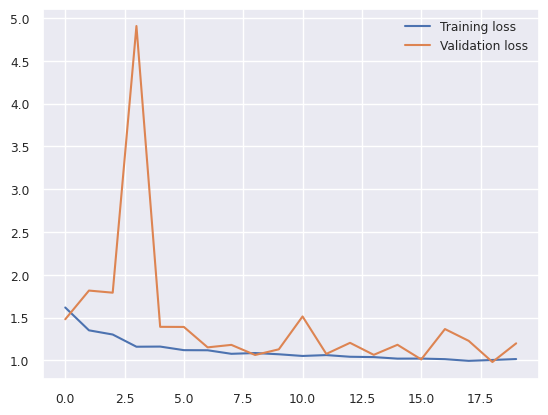

In [62]:
step = 0

#Training loop
train_losses = []
val_losses = []

for epoch in range(train_config['epochs']):
    # Model Training
    model.train()
    step += 1

    pbar = tqdm(train_dl)

    # track performance
    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['n_classes'])

    for idx, (img, y) in enumerate(pbar):
        # load target
        y = y.to(device)
        img = img.to(device)
        # model output
        y_hat = model(img)

        # loss computation
        loss = criterion(y_hat, y)

        # backward step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # get prediction
        _, pred = torch.max(y_hat, dim=1)

        epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
        metrics.add_batch(y, pred)

        pbar.set_description(f"Epoch:{epoch}, Training Loss:{epoch_losses[-100:].mean():.4}")

    mean_loss = epoch_losses.mean()
    train_losses.append(mean_loss)
    train_stats = {
            "train_loss": mean_loss.item(),
            "train_average_accuracy": metrics.get_average_accuracy(),
            "train_mIoU": metrics.get_mIoU(),
            **{
                "train_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
                "train_IoU_" + k: v
                for k, v in metrics.get_IoU().items()
            },
        }
    print(train_stats)

    # Model Validation
    model.eval()
    pbar = tqdm(val_dl)

    # track performance
    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['n_classes'])

    with torch.no_grad():
        for idx, (img, y) in enumerate(pbar):
            y = y.to(device)
            img = img.to(device)
            # model output
            y_hat = model(img)

            # loss computation
            loss = criterion(y_hat, y)

            # get prediction
            _, pred = torch.max(y_hat, dim=1)

            epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
            metrics.add_batch(y, pred)


            pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

        mean_loss = epoch_losses.mean()
        val_losses.append(mean_loss)
        val_stats = {
            "validation_loss": mean_loss.item(),
            "validation_average_accuracy": metrics.get_average_accuracy(),
            "validation_mIoU": metrics.get_mIoU(),
            **{
                "validation_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
            "train_IoU_" + k: v
            for k, v in metrics.get_IoU().items()
        },
        }

        print(f"Epoch:{epoch}", val_stats)

        # Save model checkpoint every 2 epochs
        if epoch % 2 == 0:
            if epoch == 0:
                continue

            save_weights_path = (
                "checkpoints_Unet/" + "-".join(["segmentation", "epoch", str(epoch)]) + ".pth"
            )
            torch.save(model.state_dict(), save_weights_path)

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [63]:
torch.save(model.state_dict(), train_config['model_path'])

## Test

In [64]:
def test(model, test_ld):
    model.eval()
    pbar = tqdm(test_ld)

    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['n_classes'])
    all_preds = []
    all_gts = []
    with torch.no_grad():
        for idx, (img, y) in enumerate(pbar):
            img = img.to(device)
            y = y.to(device)
            # model output
            y_hat = model(img)

            # loss computation
            loss = criterion(y_hat, y)

            # get prediction
            _, pred = torch.max(y_hat, dim=1)
            all_gts.append(y.cpu().numpy())
            all_preds.append(pred.cpu().numpy())
            epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
            metrics.add_batch(y, pred)


            pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

        mean_loss = epoch_losses.mean()
        test_stats = {
            "test_loss": mean_loss.item(),
            "test_average_accuracy": metrics.get_average_accuracy(),
            "test_mIoU": metrics.get_mIoU(),
            **{
                "test_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
                "train_IoU_" + k: v
                for k, v in metrics.get_IoU().items()
            },
        }
        print("Test stats:")

        # Loss
        print(f"  Loss: {test_stats['test_loss']:.4f}")

        # Average accuracy and mIoU
        print(f"  Average Accuracy: {test_stats['test_average_accuracy']:.4f}")
        print(f"  Mean IoU: {test_stats['test_mIoU']:.4f}")

        # Accuracy per class
        print("  Accuracy by Class:")
        for i in range(data_config['n_classes']):
            print(f"    Class {i}: {test_stats[f'test_accuracy_pixelclass_{i}']:.4f}")

        # IoU per class
        print("  IoU by Class:")
        for i in range(data_config['n_classes']):
            print(f"    Class {i}: {test_stats[f'train_IoU_class_{i}']:.4f}")
        all_preds = np.concatenate(all_preds)
        all_gts = np.concatenate(all_gts)

        # Calculer la matrice de confusion
        conf_matrix = confusion_matrix(all_gts.flatten(), all_preds.flatten(), labels=np.arange(data_config['n_classes']))
        # Normalisation par lignes
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        sns.set(font_scale=0.8)

        # Tracer la matrice de confusion
        plt.figure(figsize=(10, 10))
        ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=list(dict_classes_13.values()), yticklabels=list(dict_classes_13.values()))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        #sns.set(font_scale=1.2)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
    return

Validation Loss:1.406: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]


Test stats:
  Loss: 1.4064
  Average Accuracy: 0.3417
  Mean IoU: 0.2403
  Accuracy by Class:
    Class 0: 0.3614
    Class 1: 0.2714
    Class 2: 0.4716
    Class 3: 0.0000
    Class 4: 0.8660
    Class 5: 0.3791
    Class 6: 0.8847
    Class 7: 0.2966
    Class 8: 0.0057
    Class 9: 0.8627
    Class 10: 0.0429
    Class 11: 0.0000
    Class 12: 0.0000
  IoU by Class:
    Class 0: 0.3164
    Class 1: 0.1441
    Class 2: 0.4420
    Class 3: 0.0000
    Class 4: 0.6211
    Class 5: 0.2714
    Class 6: 0.6583
    Class 7: 0.1787
    Class 8: 0.0057
    Class 9: 0.4465
    Class 10: 0.0393
    Class 11: 0.0000
    Class 12: 0.0000


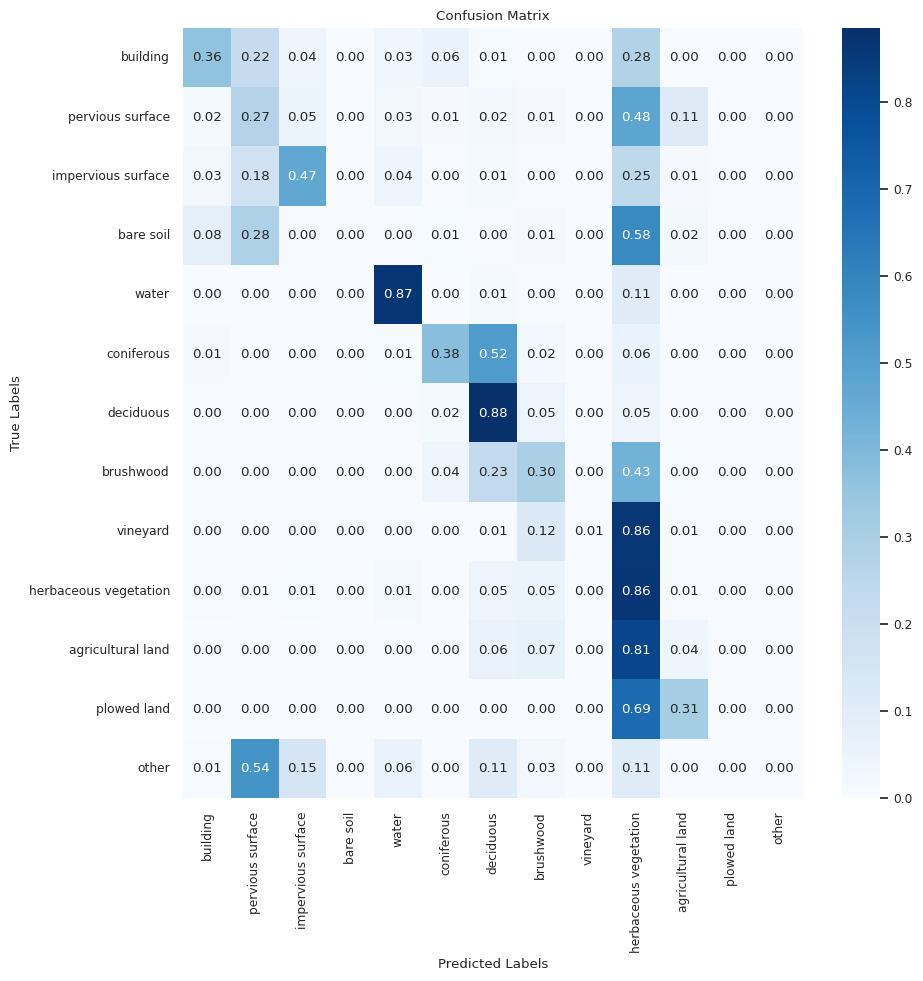

In [66]:
# create a new model's instance
model = UNet(n_classes=data_config['n_classes'], n_channels=data_config['n_inputs'])
model = model.to(device)

# load checkpoints weights
#model.load_state_dict(torch.load(train_config['model_path']))
model.load_state_dict(torch.load('checkpoints_Unet/segmentation-epoch-4.pth'))

test(model, test_dl)

Validation Loss:1.137: 100%|██████████| 17/17 [00:31<00:00,  1.86s/it]


Test stats:
  Loss: 1.1366
  Average Accuracy: 0.4337
  Mean IoU: 0.3256
  Accuracy by Class:
    Class 0: 0.7611
    Class 1: 0.2269
    Class 2: 0.8666
    Class 3: 0.0000
    Class 4: 0.8180
    Class 5: 0.3891
    Class 6: 0.8307
    Class 7: 0.2320
    Class 8: 0.6903
    Class 9: 0.8230
    Class 10: 0.0000
    Class 11: 0.0000
    Class 12: 0.0000
  IoU by Class:
    Class 0: 0.5768
    Class 1: 0.1316
    Class 2: 0.5431
    Class 3: 0.0000
    Class 4: 0.6323
    Class 5: 0.3282
    Class 6: 0.6756
    Class 7: 0.1881
    Class 8: 0.6598
    Class 9: 0.4975
    Class 10: 0.0000
    Class 11: 0.0000
    Class 12: 0.0000


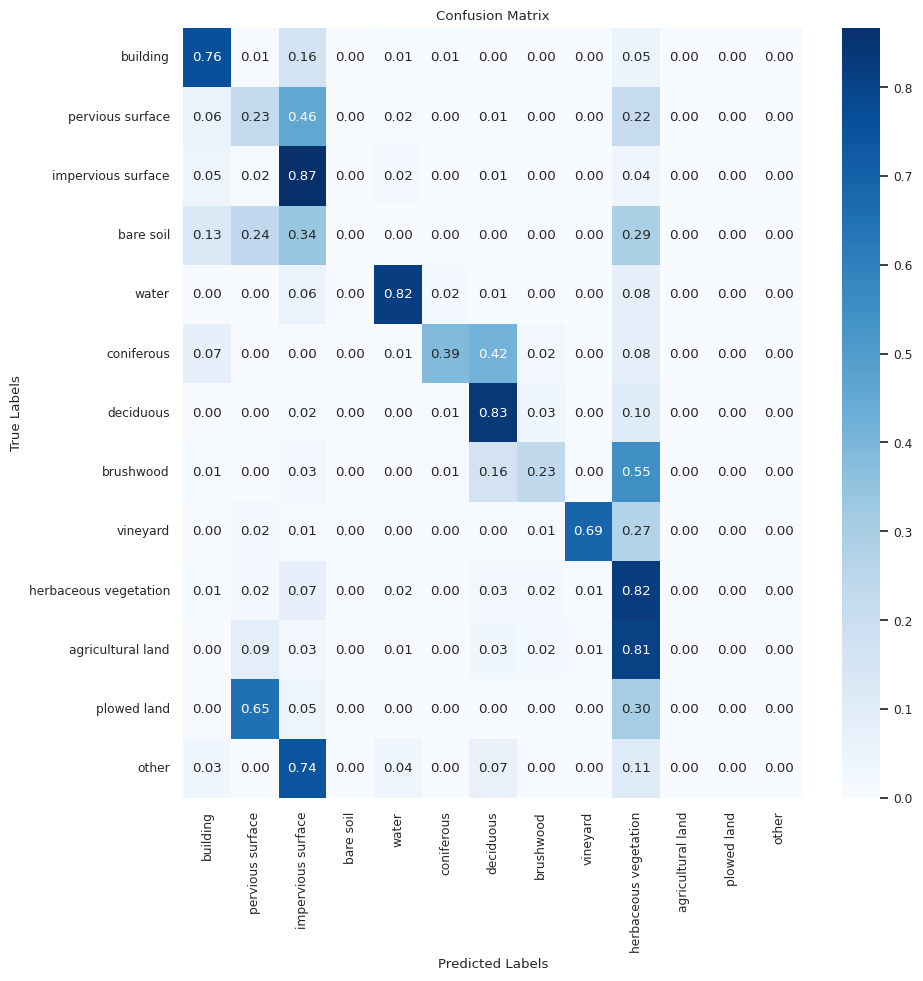

In [67]:
# create a new model's instance
model = UNet(n_classes=data_config['n_classes'], n_channels=data_config['n_inputs'])
model = model.to(device)

# load checkpoints weights
#model.load_state_dict(torch.load(train_config['model_path']))
model.load_state_dict(torch.load('checkpoints_Unet/segmentation-epoch-6.pth'))

test(model, test_dl)

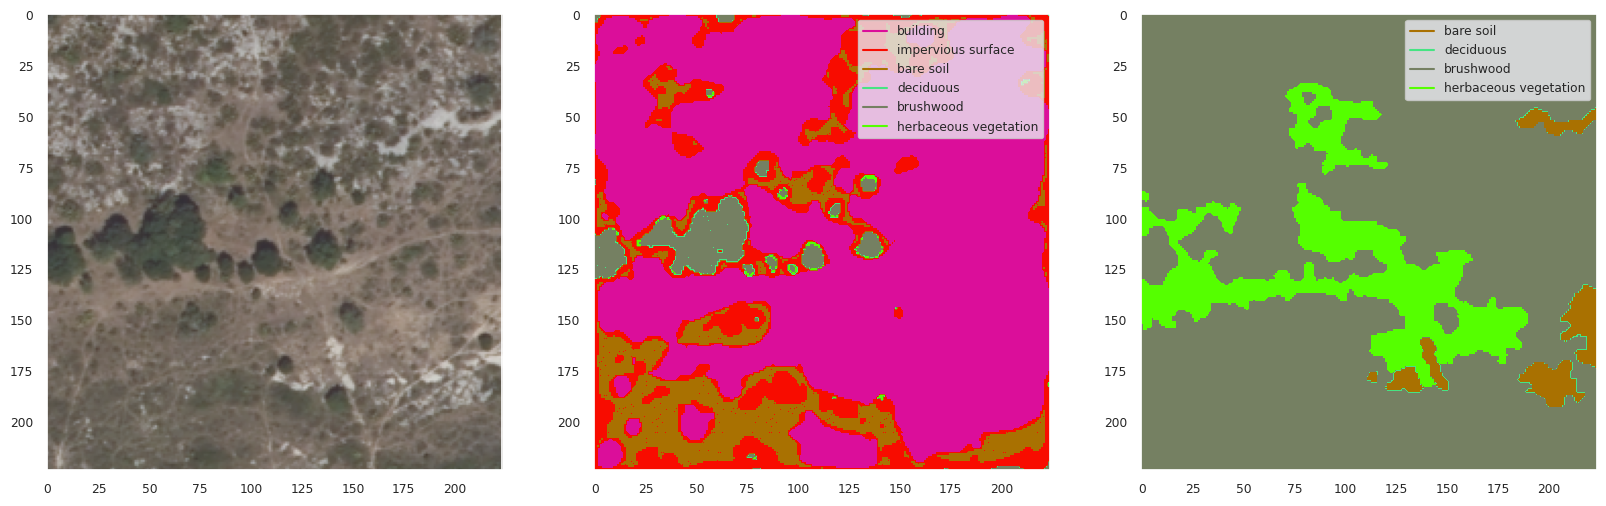

In [47]:
img, target = next(iter(val_dl))
pred = model(img.cuda()).cpu().detach()
plot_pred(img[0], pred[0], target[0], dict_classes_13, colors_13)